In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
#pip install -r requirements.txt

In [4]:
import torch

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [39]:
import matplotlib.pyplot as plt
from data_util import get_data_from_kaggle, sentiment_analysis , aggregate_tweet, restructure_date_information, get_static_df, one_label_scale_static_df, scale_stock_data
from constant import Constant
import pandas as pd
from torch import optim
from TFT import TFT_embedding, TFT, QuantilesLoss
from data import TFT_Dataset
from torch.utils.data import DataLoader ,random_split
from data_util import get_feature_length


In [7]:
TFT

TFT.tft.TFT

In [36]:
constant = Constant()
constant

In [271]:
stock = get_data_from_kaggle(market = 'sp500', start_date = '01-01-2015')

c:\Users\Luan\Documents\DL\TFT\data_util.py:32: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])


In [127]:
#tweet = pd.read_csv('processed.csv')
#tweet
#aggregated_tweet = aggregate_tweet(tweet)
#aggregated_tweet

In [272]:
stock

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
3803,2015-01-02,40.369999,41.180000,1529200.0,41.310001,40.560001,37.941975,A
3804,2015-01-05,39.700001,40.320000,2041800.0,40.459999,39.799999,37.231033,A
3805,2015-01-06,39.020000,39.810001,2080600.0,40.020000,39.180000,36.651058,A
3806,2015-01-07,39.290001,39.520000,3359700.0,39.810001,39.700001,37.137489,A
3807,2015-01-08,40.180000,40.240002,2116300.0,40.980000,40.889999,38.250675,A
...,...,...,...,...,...,...,...,...
3265995,2022-12-06,152.089996,154.220001,1964800.0,155.500000,153.050003,153.050003,ZTS
3265996,2022-12-07,149.380005,152.960007,2444100.0,153.789993,150.250000,150.250000,ZTS
3265997,2022-12-08,149.199997,150.529999,2267500.0,154.350006,153.679993,153.679993,ZTS
3265998,2022-12-09,152.740005,153.940002,3274900.0,156.330002,153.389999,153.389999,ZTS


In [273]:
static = get_static_df(stock,  constant.static_variables)

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABC&crumb=fLdCV4HntgB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABMD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABMD&crumb=fLdCV4HntgB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATVI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATVI&crumb=fLdCV4HntgB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FLT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.c

In [277]:
static.loc["AAPL"].values

array(['Consumer Electronics', 'Technology', 'United States', 1.24,
       3587432775680, 3.767, 1.0, 0.0042, 0.62, 209.059], dtype=object)

In [278]:
valid_tickers = static.index
stock = stock[stock['Stock Name'].isin(valid_tickers)]

In [279]:
stock

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
3803,2015-01-02,40.369999,41.180000,1529200.0,41.310001,40.560001,37.941975,A
3804,2015-01-05,39.700001,40.320000,2041800.0,40.459999,39.799999,37.231033,A
3805,2015-01-06,39.020000,39.810001,2080600.0,40.020000,39.180000,36.651058,A
3806,2015-01-07,39.290001,39.520000,3359700.0,39.810001,39.700001,37.137489,A
3807,2015-01-08,40.180000,40.240002,2116300.0,40.980000,40.889999,38.250675,A
...,...,...,...,...,...,...,...,...
3265995,2022-12-06,152.089996,154.220001,1964800.0,155.500000,153.050003,153.050003,ZTS
3265996,2022-12-07,149.380005,152.960007,2444100.0,153.789993,150.250000,150.250000,ZTS
3265997,2022-12-08,149.199997,150.529999,2267500.0,154.350006,153.679993,153.679993,ZTS
3265998,2022-12-09,152.740005,153.940002,3274900.0,156.330002,153.389999,153.389999,ZTS


In [280]:
stock_scaled, stock_scalar = scale_stock_data(stock, constant.columns_to_scale)
stock_scaled

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
0,2015-01-02,0.050330,0.054757,0.093554,0.049825,0.049277,0.044243,A
1,2015-01-05,0.045679,0.048871,0.129311,0.043983,0.044068,0.039389,A
2,2015-01-06,0.040958,0.045380,0.132018,0.040959,0.039819,0.035429,A
3,2015-01-07,0.042832,0.043395,0.221242,0.039516,0.043383,0.038750,A
4,2015-01-08,0.049011,0.048323,0.134508,0.047557,0.051539,0.046351,A
...,...,...,...,...,...,...,...,...
811516,2022-12-06,0.551851,0.553852,0.081067,0.552923,0.547520,0.555969,ZTS
811517,2022-12-07,0.538773,0.547796,0.104422,0.544770,0.534039,0.542481,ZTS
811518,2022-12-08,0.537905,0.536118,0.095817,0.547440,0.550554,0.559004,ZTS
811519,2022-12-09,0.554987,0.552506,0.144905,0.556880,0.549157,0.557607,ZTS


In [284]:
# merged_df = pd.merge(aggregated_tweet, stock_scaled, on=['Date', 'Stock Name'], how='right')
# merged_df = merged_df.fillna(0)

In [285]:
processed_df = restructure_date_information(stock_scaled)
processed_df

,Low,Open,Volume,High,Close,Adjusted Close,Stock Name,Month,Day,Day of The Year,Day of The Week,Week of The Year
0,0.050330,0.054757,0.093554,0.049825,0.049277,0.044243,A,0,1,2,4,0
1,0.045679,0.048871,0.129311,0.043983,0.044068,0.039389,A,0,4,5,0,1
2,0.040958,0.045380,0.132018,0.040959,0.039819,0.035429,A,0,5,6,1,1
3,0.042832,0.043395,0.221242,0.039516,0.043383,0.038750,A,0,6,7,2,1
4,0.049011,0.048323,0.134508,0.047557,0.051539,0.046351,A,0,7,8,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
811516,0.551851,0.553852,0.081067,0.552923,0.547520,0.555969,ZTS,11,5,340,1,48
811517,0.538773,0.547796,0.104422,0.544770,0.534039,0.542481,ZTS,11,6,341,2,48
811518,0.537905,0.536118,0.095817,0.547440,0.550554,0.559004,ZTS,11,7,342,3,48
811519,0.554987,0.552506,0.144905,0.556880,0.549157,0.557607,ZTS,11,8,343,4,48


In [286]:
processed_df.nunique()

Low                 632900
Open                628048
Volume              724138
High                632026
Close               632100
Adjusted Close      718257
Stock Name             409
Month                   12
Day                     31
Day of The Year        364
Day of The Week          5
Week of The Year        53
dtype: int64

In [287]:
static_df = one_label_scale_static_df(static,constant.static_variables)

In [288]:
history_cat_feature_num_list, history_cont_feature_num = get_feature_length(processed_df, constant.feature_variables)
static_cat_feature_num_list , static_cont_feature_num  = get_feature_length(static, constant.static_variables)
future_feature_num          , _                        = get_feature_length(processed_df, constant.future_feature)
_                           , prediction_con           = get_feature_length(processed_df, constant.prediction_feature)

In [289]:
static_cat_feature_num_list


[108, 12, 12]

In [290]:
history_length = 90
prediction_length = 15
hidden_size = 128
batch_size = 128
dropout = .2
num_head = 4
lr= 0.0001
momentum=0.9
num_epochs = 10
max_grad_norm = 1
split_ratio = 0.8

In [291]:
tft_Dataset = TFT_Dataset(stock_df= processed_df , 
                static_df=static_df,
                constant_variable=constant, 
                history_length= history_length, 
                prediction_length= prediction_length, 
                device = device)

In [292]:
train_size = int(0.8 * tft_Dataset.__len__())
test_size = len(tft_Dataset) - train_size

In [293]:
train_dataset, test_dataset = random_split(tft_Dataset, [train_size, test_size])

In [294]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

In [295]:
count =0
for static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction in train_loader:
    break
print(static_cont_input.size(), static_cont_input.device)


torch.Size([128, 7]) cuda:0


In [296]:
model = TFT(static_cat_feature_num_list= static_cat_feature_num_list,
            static_cont_feature_num=static_cont_feature_num,
            history_cat_feature_num_list= history_cat_feature_num_list,
            history_cont_feature_num=history_cont_feature_num,
            future_feature_list=future_feature_num,
            history_len = history_length,
            future_len = prediction_length,
            dropout= dropout,
            num_head = num_head,
            hidden_size = hidden_size,
            device = device)
model.to(device)

TFT(
  (tft_embed): TFT_embedding(
    (static_cont): Linear(in_features=7, out_features=128, bias=True)
    (static_cat): ModuleList(
      (0): Embedding(108, 128)
      (1-2): 2 x Embedding(12, 128)
    )
    (history_cont): Linear(in_features=4, out_features=128, bias=True)
    (history_cat): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(53, 128)
    )
    (future_feature): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(53, 128)
    )
  )
  (cs): VariationSelection(
    (group_GRN): GRN(
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (GLU): GLU(
        (linear4): Linear(in_features=128, out_features=512, bias=True)
        (linear5): Linear(in_features=128, out_features=512, bias=True)
      )
      (droput): Dropout(p=0.0, inplace=Fal

In [297]:
loss_function = QuantilesLoss(device= device)
loss_function.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)

In [298]:
model.train()
batch_loss = [] 
for epoch in range(num_epochs):
    for i, (static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction) in enumerate(train_loader):
        predicted = model(static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input)
        optimizer.zero_grad()
        losses = loss_function(predicted = predicted, targets = prediction)
        loss = losses.sum()
        loss.backward()

        max_grad_norm = 1.0  # Set a threshold for the maximum gradient norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
    batch_loss.append(loss.item())

    print(f'Epoch: {epoch+1},  Loss: {loss.item()}')

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "tft_model.pth")


In [30]:
if next(model.parameters()).is_cuda:
    print("Model is on GPU")
else:
    print("Model is on CPU")

Model is on CPU


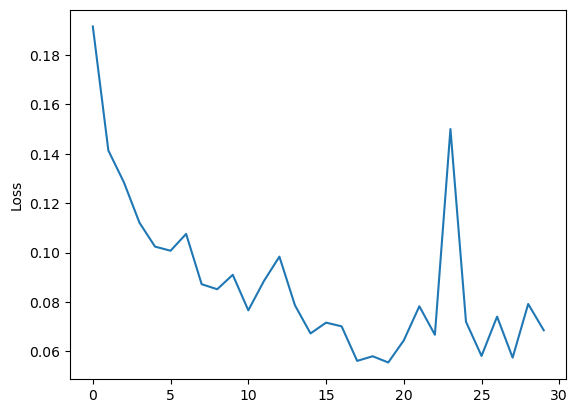

In [ ]:
x = range(len(batch_loss))
plt.plot(x, batch_loss)
plt.ylabel('Loss')
plt.show()

In [1]:
pwd

'c:\\Users\\Luan\\Documents\\DL\\TFT'

In [ ]:
import kagglehub


100%|██████████| 1.03G/1.03G [01:44<00:00, 10.6MB/s]

Extracting files...


Path to dataset files: C:\Users\Luan\.cache\kagglehub\datasets\paultimothymooney\stock-market-data\versions\74


In [ ]:
C:\Users\Luan\.cache\kagglehub\datasets\paultimothymooney\stock-market-data\versions\74\stock_market_data\sp500\csv

'C:\\Users\\Luan\\.cache\\kagglehub\\datasets\\paultimothymooney\\stock-market-data\\versions\\74'

In [ ]:
import glob
import pandas as pd

    path = kagglehub.dataset_download("paultimothymooney/stock-market-data")
    s = 'sp500'
    path_to_files = path + f"\\stock_market_data\\{s}\\csv\\*.csv"

    csv_files = glob.glob(path_to_files)
    dataframes = []

    for file in csv_files:
        ticker = file.split("\\")[-1].replace(".csv", "")

        df = pd.read_csv(file)
        df['Stock Name'] = ticker
        
        dataframes.append(df)
    final_dataframe = pd.concat(dataframes, ignore_index=True)
    final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'])
    final_dataframe = final_dataframe[final_dataframe['Date'] >= '01-01-2010']
return final_dataframe


In [32]:
path_to_files

'C:\\Users\\Luan\\.cache\\kagglehub\\datasets\\paultimothymooney\\stock-market-data\\versions\\74\\stock_market_data\\sp500\\csv\\*.csv'

In [33]:
final_dataframe['Date'].max()

'31-12-2021'

In [ ]:
final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'])
final_dataframe = final_dataframe[final_dataframe['Date'] >= '01-01-2010']

C:\Users\Luan\AppData\Local\Temp\ipykernel_10600\720223884.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'])


In [ ]:
final_dataframe.nunique()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
2545,2010-01-04,22.267525,22.453505,3815561.0,22.625179,22.389128,20.331635,A
2546,2010-01-05,22.002861,22.324751,4186031.0,22.331903,22.145924,20.110781,A
2547,2010-01-06,22.002861,22.067240,3243779.0,22.174536,22.067240,20.039324,A
2548,2010-01-07,21.816881,22.017166,3095172.0,22.045780,22.038628,20.013346,A
2549,2010-01-08,21.745352,21.917025,3733918.0,22.067240,22.031473,20.006849,A


In [41]:
test_static = get_static_df(final_dataframe,  constant.static_variables)

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABC&crumb=fLdCV4HntgB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABMD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABMD&crumb=fLdCV4HntgB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATVI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATVI&crumb=fLdCV4HntgB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FLT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.c

In [53]:
test_static.head()

,industry,sector,country,beta,marketCap,bookValue,dividendRate,dividendYield,fiveYearAvgDividendYield,debtToEquity
A,Diagnostics & Research,Healthcare,United States,1.072,39396507648,20.530,0.99,0.0074,0.66,52.787
AAL,Airlines,Industrials,United States,1.399,9620400128,-7.387,0.00,0.0000,1.27,0.000
AAP,Specialty Retail,Consumer Cyclical,United States,1.194,2654599680,42.340,1.00,0.0243,2.44,171.801
AAPL,Consumer Electronics,Technology,United States,1.240,3587432775680,3.767,1.00,0.0042,0.62,209.059
ABBV,Drug Manufacturers - General,Healthcare,United States,0.613,323528163328,3.413,6.56,0.0359,4.13,1174.815


In [54]:
valid_tickers = test_static.index
final_dataframe = final_dataframe[final_dataframe['Stock Name'].isin(valid_tickers)]

In [55]:
final_dataframe.reset_index(drop=True)

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
0,18-11-1999,28.612303,32.546494,62546380.0,35.765381,31.473534,26.929760,A
1,19-11-1999,28.478184,30.713518,15234146.0,30.758226,28.880545,24.711119,A
2,22-11-1999,28.657009,29.551144,6577870.0,31.473534,31.473534,26.929760,A
3,23-11-1999,28.612303,30.400572,5975611.0,31.205294,28.612303,24.481602,A
4,24-11-1999,28.612303,28.701717,4843231.0,29.998213,29.372318,25.131901,A
...,...,...,...,...,...,...,...,...
3265995,06-12-2022,152.089996,154.220001,1964800.0,155.500000,153.050003,153.050003,ZTS
3265996,07-12-2022,149.380005,152.960007,2444100.0,153.789993,150.250000,150.250000,ZTS
3265997,08-12-2022,149.199997,150.529999,2267500.0,154.350006,153.679993,153.679993,ZTS
3265998,09-12-2022,152.740005,153.940002,3274900.0,156.330002,153.389999,153.389999,ZTS


In [56]:
final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'])
final_dataframe = final_dataframe[final_dataframe['Date'] >= '01-01-2010']

C:\Users\Luan\AppData\Local\Temp\ipykernel_10600\2406221053.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'])


In [57]:
final_dataframe

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
2545,2010-01-04,22.267525,22.453505,3815561.0,22.625179,22.389128,20.331635,A
2546,2010-01-05,22.002861,22.324751,4186031.0,22.331903,22.145924,20.110781,A
2547,2010-01-06,22.002861,22.067240,3243779.0,22.174536,22.067240,20.039324,A
2548,2010-01-07,21.816881,22.017166,3095172.0,22.045780,22.038628,20.013346,A
2549,2010-01-08,21.745352,21.917025,3733918.0,22.067240,22.031473,20.006849,A
...,...,...,...,...,...,...,...,...
3265995,2022-12-06,152.089996,154.220001,1964800.0,155.500000,153.050003,153.050003,ZTS
3265996,2022-12-07,149.380005,152.960007,2444100.0,153.789993,150.250000,150.250000,ZTS
3265997,2022-12-08,149.199997,150.529999,2267500.0,154.350006,153.679993,153.679993,ZTS
3265998,2022-12-09,152.740005,153.940002,3274900.0,156.330002,153.389999,153.389999,ZTS
